https://jovian.ai/aakanksha-ns/road-signs-bounding-box-prediction

In [1]:
#library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

import torch 
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score
from torch.utils.tensorboard import SummaryWriter

def set_all_seeds(SEED):
    # REPRODUCIBILITY
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

from glob import glob
import ipdb

import warnings
warnings.filterwarnings('ignore')


## Loading the data

In [2]:
data = pd.read_csv('D:\\Data\\AI604_project\\NIH\\Data_Entry_2017.csv')
data = data[data['Patient Age']<100] #removing datapoints which having age greater than 100
data_image_paths = {os.path.basename(x): x for x in 
                        glob(os.path.join('D:\\Data\\AI604_project\\NIH', 'images*', '*', '*.png'))}

print('Scans found:', len(data_image_paths), ', Total Headers', data.shape[0])  # Scans found: 112120 , Total Headers 112104
data['path'] = data['Image Index'].map(data_image_paths.get)
data['Patient Age'] = data['Patient Age'].map(lambda x: int(x))
data['Finding Labels'] = data['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

from itertools import chain
all_labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        data[c_label] = data['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
#print("\n",list(data))

MIN_CASES = 1000

data['disease_vec'] = data.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])
data.sample(3)

Scans found: 112120 , Total Headers 112104
All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,disease_vec
38614,00010085_000.png,Mass,0,10085,53,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
46332,00011845_005.png,,5,11845,65,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
76084,00018665_001.png,Infiltration,1,18665,60,M,PA,2954,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."


In [4]:
anno_path = pd.read_csv('D:\\Data\\AI604_project\\NIH\\BBox_List_2017.csv')
anno_df = anno_path.loc[:,['Image Index','Finding Label','Bbox [x','y','w','h]']]   # drop uncecessary columns
anno_df['Image Index'] = anno_df['Image Index'].map(data_image_paths.get)
anno_df.rename(columns={'Bbox [x':'x',"h]":'h'}, inplace=True)
anno_df[:5]

,Image Index,Finding Label,x,y,w,h
0,D:\Data\AI604_project\NIH\images_006\images\00...,Atelectasis,225.084746,547.019217,86.779661,79.186441
1,D:\Data\AI604_project\NIH\images_007\images\00...,Atelectasis,686.101695,131.543498,185.491525,313.491525
2,D:\Data\AI604_project\NIH\images_012\images\00...,Atelectasis,221.830508,317.053115,155.118644,216.949153
3,D:\Data\AI604_project\NIH\images_007\images\00...,Atelectasis,726.237288,494.951420,141.016949,55.322034
4,D:\Data\AI604_project\NIH\images_008\images\00...,Atelectasis,660.067797,569.780787,200.677966,78.101695


In [5]:
# label -> number
anno_df['Finding Label'] = anno_df['Finding Label'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*anno_df['Finding Label'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
# print(anno_df)
for c_label in all_labels:
    anno_df[c_label] = anno_df['Finding Label'].map(lambda finding: 1.0 if c_label in finding else 0)
anno_df['disease_vec'] = anno_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

anno_df

All Labels (8): ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltrate', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Label,x,y,w,h,Atelectasis,Cardiomegaly,Effusion,Infiltrate,Mass,Nodule,Pneumonia,Pneumothorax,disease_vec
0,D:\Data\AI604_project\NIH\images_006\images\00...,Atelectasis,225.084746,547.019217,86.779661,79.186441,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,D:\Data\AI604_project\NIH\images_007\images\00...,Atelectasis,686.101695,131.543498,185.491525,313.491525,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,D:\Data\AI604_project\NIH\images_012\images\00...,Atelectasis,221.830508,317.053115,155.118644,216.949153,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,D:\Data\AI604_project\NIH\images_007\images\00...,Atelectasis,726.237288,494.951420,141.016949,55.322034,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,D:\Data\AI604_project\NIH\images_008\images\00...,Atelectasis,660.067797,569.780787,200.677966,78.101695,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,D:\Data\AI604_project\NIH\images_012\images\00...,Atelectasis,198.940451,352.900747,615.537778,323.128889,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
980,D:\Data\AI604_project\NIH\images_011\images\00...,Atelectasis,701.838229,572.491858,103.537778,63.715556,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
981,D:\Data\AI604_project\NIH\images_008\images\00...,Atelectasis,140.913785,658.962969,271.928889,94.435556,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
982,D:\Data\AI604_project\NIH\images_009\images\00...,Atelectasis,175.047118,580.456302,244.622222,103.537778,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [6]:
class_col = []
for index, row in anno_df.iterrows() :
    #print(row['disease_vec'])
    index_disease = np.where(row['disease_vec'] == 1.0)
    #print(index_disease[0])
    class_col.append(index_disease[0][0])
anno_df['Finding Label'] = class_col
anno_df = anno_df.drop(anno_df.columns[6:], axis=1)
anno_df


,Image Index,Finding Label,x,y,w,h
0,D:\Data\AI604_project\NIH\images_006\images\00...,0,225.084746,547.019217,86.779661,79.186441
1,D:\Data\AI604_project\NIH\images_007\images\00...,0,686.101695,131.543498,185.491525,313.491525
2,D:\Data\AI604_project\NIH\images_012\images\00...,0,221.830508,317.053115,155.118644,216.949153
3,D:\Data\AI604_project\NIH\images_007\images\00...,0,726.237288,494.951420,141.016949,55.322034
4,D:\Data\AI604_project\NIH\images_008\images\00...,0,660.067797,569.780787,200.677966,78.101695
...,...,...,...,...,...,...
979,D:\Data\AI604_project\NIH\images_012\images\00...,0,198.940451,352.900747,615.537778,323.128889
980,D:\Data\AI604_project\NIH\images_011\images\00...,0,701.838229,572.491858,103.537778,63.715556
981,D:\Data\AI604_project\NIH\images_008\images\00...,0,140.913785,658.962969,271.928889,94.435556
982,D:\Data\AI604_project\NIH\images_009\images\00...,0,175.047118,580.456302,244.622222,103.537778


In [7]:
# https://csm-kr.tistory.com/13
def center_to_corner(center_boxes):
    """
    input
    center_boxes : center coordinates boxes : [N, 4] (cx, cy, w, h)
    output
    corner_boxes : corner coordinates boxes : [N, 4] (x1, y1, x2, y2)
    """
    center_boxes['xmin'] = center_boxes.loc[:,'x'] - (center_boxes.loc[:,'w'])/2
    center_boxes['ymin'] = center_boxes.loc[:,'y'] - (center_boxes.loc[:,'h'])/2
    center_boxes['xmax'] = center_boxes.loc[:,'x'] + (center_boxes.loc[:,'w'])/2
    center_boxes['ymax'] = center_boxes.loc[:,'y'] + (center_boxes.loc[:,'h'])/2



    return center_boxes

In [8]:
df_train = center_to_corner(anno_df)
df_train.head()

,Image Index,Finding Label,x,y,w,h,xmin,ymin,xmax,ymax
0,D:\Data\AI604_project\NIH\images_006\images\00...,0,225.084746,547.019217,86.779661,79.186441,181.694915,507.425996,268.474576,586.612437
1,D:\Data\AI604_project\NIH\images_007\images\00...,0,686.101695,131.543498,185.491525,313.491525,593.355932,-25.202264,778.847458,288.289261
2,D:\Data\AI604_project\NIH\images_012\images\00...,0,221.830508,317.053115,155.118644,216.949153,144.271186,208.578539,299.389831,425.527691
3,D:\Data\AI604_project\NIH\images_007\images\00...,0,726.237288,494.951420,141.016949,55.322034,655.728814,467.290403,796.745763,522.612437
4,D:\Data\AI604_project\NIH\images_008\images\00...,0,660.067797,569.780787,200.677966,78.101695,559.728814,530.729939,760.406780,608.831634


In [9]:
df_train.loc[df_train['xmin'] < 0, 'xmin'] = 0
df_train.loc[df_train['ymin'] < 0, 'ymin'] = 0
df_train.loc[df_train['xmax'] < 0, 'xmax'] = 0
df_train.loc[df_train['ymax'] < 0, 'ymax'] = 0
df_train

,Image Index,Finding Label,x,y,w,h,xmin,ymin,xmax,ymax
0,D:\Data\AI604_project\NIH\images_006\images\00...,0,225.084746,547.019217,86.779661,79.186441,181.694915,507.425996,268.474576,586.612437
1,D:\Data\AI604_project\NIH\images_007\images\00...,0,686.101695,131.543498,185.491525,313.491525,593.355932,0.000000,778.847458,288.289261
2,D:\Data\AI604_project\NIH\images_012\images\00...,0,221.830508,317.053115,155.118644,216.949153,144.271186,208.578539,299.389831,425.527691
3,D:\Data\AI604_project\NIH\images_007\images\00...,0,726.237288,494.951420,141.016949,55.322034,655.728814,467.290403,796.745763,522.612437
4,D:\Data\AI604_project\NIH\images_008\images\00...,0,660.067797,569.780787,200.677966,78.101695,559.728814,530.729939,760.406780,608.831634
...,...,...,...,...,...,...,...,...,...,...
979,D:\Data\AI604_project\NIH\images_012\images\00...,0,198.940451,352.900747,615.537778,323.128889,0.000000,191.336302,506.709340,514.465191
980,D:\Data\AI604_project\NIH\images_011\images\00...,0,701.838229,572.491858,103.537778,63.715556,650.069340,540.634080,753.607118,604.349635
981,D:\Data\AI604_project\NIH\images_008\images\00...,0,140.913785,658.962969,271.928889,94.435556,4.949340,611.745191,276.878229,706.180747
982,D:\Data\AI604_project\NIH\images_009\images\00...,0,175.047118,580.456302,244.622222,103.537778,52.736007,528.687413,297.358229,632.225191


In [10]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [11]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    #print("x shape : ", x.shape)
    Y = np.zeros((rows, cols))
    #print("Y shape", Y.shape)
    bb = bb.astype(np.int)
    #print(bb[0],bb[2], bb[1], bb[3])
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    #print(Y[bb[0]:bb[2], bb[1]:bb[3]])
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    #print(cols, rows)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[7],x[6],x[9],x[8]])

In [13]:
#Populating Training DF with new paths and bounding boxes
new_bbs = []
for index, row in df_train.iterrows():
    # print(row['Image Index'])
    im = read_image(row['Image Index'])
    bb = create_bb_array(row.values)
    
    Y = create_mask(bb, im)
    new_bb = mask_to_bb(Y)
    new_bbs.append(new_bb)
df_train['new_bb'] = new_bbs

In [14]:
df_train

,Image Index,Finding Label,x,y,w,h,xmin,ymin,xmax,ymax,new_bb
0,D:\Data\AI604_project\NIH\images_006\images\00...,0,225.084746,547.019217,86.779661,79.186441,181.694915,507.425996,268.474576,586.612437,"[507.0, 181.0, 585.0, 267.0]"
1,D:\Data\AI604_project\NIH\images_007\images\00...,0,686.101695,131.543498,185.491525,313.491525,593.355932,0.000000,778.847458,288.289261,"[0.0, 593.0, 287.0, 777.0]"
2,D:\Data\AI604_project\NIH\images_012\images\00...,0,221.830508,317.053115,155.118644,216.949153,144.271186,208.578539,299.389831,425.527691,"[208.0, 144.0, 424.0, 298.0]"
3,D:\Data\AI604_project\NIH\images_007\images\00...,0,726.237288,494.951420,141.016949,55.322034,655.728814,467.290403,796.745763,522.612437,"[467.0, 655.0, 521.0, 795.0]"
4,D:\Data\AI604_project\NIH\images_008\images\00...,0,660.067797,569.780787,200.677966,78.101695,559.728814,530.729939,760.406780,608.831634,"[530.0, 559.0, 607.0, 759.0]"
...,...,...,...,...,...,...,...,...,...,...,...
979,D:\Data\AI604_project\NIH\images_012\images\00...,0,198.940451,352.900747,615.537778,323.128889,0.000000,191.336302,506.709340,514.465191,"[191.0, 0.0, 513.0, 505.0]"
980,D:\Data\AI604_project\NIH\images_011\images\00...,0,701.838229,572.491858,103.537778,63.715556,650.069340,540.634080,753.607118,604.349635,"[540.0, 650.0, 603.0, 752.0]"
981,D:\Data\AI604_project\NIH\images_008\images\00...,0,140.913785,658.962969,271.928889,94.435556,4.949340,611.745191,276.878229,706.180747,"[611.0, 4.0, 705.0, 275.0]"
982,D:\Data\AI604_project\NIH\images_009\images\00...,0,175.047118,580.456302,244.622222,103.537778,52.736007,528.687413,297.358229,632.225191,"[528.0, 52.0, 631.0, 296.0]"


## Sample Image


In [29]:
im = cv2.imread(str(df_train.values[15][0]))
bb = create_bb_array(df_train.values[15])
print(im.shape)

(1024, 1024, 3)


In [30]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([336., 501., 483., 756.], dtype=float32)

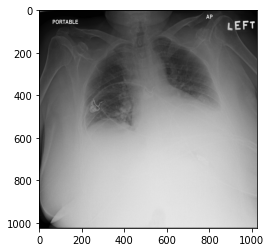

In [31]:
plt.imshow(im)

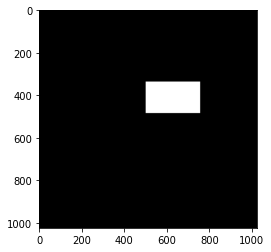

In [32]:
plt.imshow(Y, cmap='gray')

In [26]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

Labels :  0


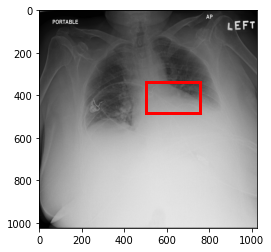

In [27]:
#original
print("Labels : " , str(df_train.values[15][1]))
im = cv2.imread(str(df_train.values[15][0]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[15][10])